## mbti-SVM

### 1 Import packages and load preprocessed dataframe

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import pickle as pk
import random
import time
from pprint import pprint
from tqdm import tqdm
from joblib import Parallel, delayed
from utilities import clean_posts, postVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier,plot_importance

method_dict = {
    'RF': 'RandomForest',
    'SVM': 'SVM',
    'XGB': 'XGBoost',
    'DL': 'DeepLearning'
}

type_dict = {
    0: ['I', 'N', 'T', 'J'],
    1: ['E', 'S', 'F', 'P']
}

with open('pickles/type_explanation.pk', 'rb') as pkl:
    type_explanation = pk.load(pkl)
    
type_keys = list(type_explanation.keys())

In [2]:
with open('pickles/tfidf_df.pk', 'rb') as pkl:
    tfidf_df = pk.load(pkl)

with open('pickles/df.pk', 'rb') as pkl:
    df = pk.load(pkl)

with open('pickles/clf_ie.pk', 'rb') as pkl:
    clf_ie = pk.load(pkl)

with open('pickles/clf_ns.pk', 'rb') as pkl:
    clf_ns = pk.load(pkl)

with open('pickles/clf_tf.pk', 'rb') as pkl:
    clf_tf = pk.load(pkl)

with open('pickles/clf_jp.pk', 'rb') as pkl:
    clf_jp = pk.load(pkl)

### 2 Training and Benchmarking

In [42]:
benchmark_df = pd.DataFrame(np.zeros((3, 6)), index=['Scale','ACC', 'F1'], columns=['IE', 'NS','TF', 'JP', 'Full Type(Strict)', 'Full Type(Loose)'])

In [85]:
# train_by_type
# @params:
#     _type: (string), type to be classified; types:[IE, NS, TF, JP]
#    method: (string), type of the classifier; methods:['RF', 'SVM', 'XGB']
# benchmark: (boolean), whether benchmark on dataset; benchmark:[True, False]
##

def train_by_type(_type, method='RF', benchmark=False):
    print(">>> Training Type {} ".format(_type)+"="*60)
    y = df[_type].values
    if method == 'RF':
        y = y.reshape(-1, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(tfidf_df.values, y, test_size=0.2, train_size=0.8,
                                                        random_state=None, shuffle=True, stratify=y)
    
    print("# @Training START #")
    if method == 'RF':
        clf = RandomForest(n_estimators=100, verbose=0, min_leaf_size=3)
        clf.fit(np.concatenate((X_train, y_train), axis=1))
    
    elif method == 'SVM':
        clf = LinearSVC(tol=1e-5)
        clf.fit(X_train, y_train)
    
    elif method == 'XGB':
        clf = XGBClassifier()
        clf.fit(X_train, y_train, 
                early_stopping_rounds=10,
                eval_metric="logloss",
                eval_set=[(X_test, y_test)],
                verbose=False)
    else:
        raise ValueError("Invalid Method.")
        
    print("# @Training END #\n")
    
    time.sleep(0.5)
    
    if benchmark:
        print("# @Scoring START # --- {:s}".format(method_dict[method]))
        time.sleep(0.5)
        print("Type: {}: {} : {} = {} : {}".format(_type, _type[0], _type[1], sum(y)/len(y), 1-sum(y)/len(y)))
        benchmark_df.loc['Scale', _type] = "{}% : {}%".format(int(sum(y)/len(y)*100+0.5), int((1 - sum(y)/len(y))*100+0.5))
        time.sleep(0.5)
        pred_train = [clf.predict(i.reshape(1,-1))[0] for i in tqdm(X_train)]
        acc = accuracy_score(y_train, pred_train)
        print("Accuracy on training set - %s" % _type, acc)
        benchmark_df.loc['ACC', _type] = acc
        f1 = f1_score(y_train, pred_train) if len(set(pred_train))>1 else 0.0
        print("F1 Score on training set - %s" % _type, f1)
        benchmark_df.loc['F1', _type] = f1
        time.sleep(0.5)
        pred_test = [clf.predict(i.reshape(1,-1))[0] for i in tqdm(X_test)]
        print("Accuracy on testing set - %s" % _type, accuracy_score(y_test, pred_test))
        print("F1 Score on testing set - %s" % _type, \
              (f1_score(y_test, pred_test) if len(set(pred_test))>1 else 0.0))
        print("# @Scoring END #\n")
    
    return clf

In [86]:
# Separately benchmarking
clf_ie = train_by_type('IE', 'SVM', benchmark=True)
clf_ns = train_by_type('NS', 'SVM', benchmark=True)
clf_tf = train_by_type('TF', 'SVM', benchmark=True)
clf_jp = train_by_type('JP', 'SVM', benchmark=True)

>>> Training Type IE ============================================================
# @Training START #
# @Training END #

# @Scoring START # --- SVM
Type: IE: I : E = 0.2304322766570605 : 0.7695677233429394


100%|██████████| 6940/6940 [00:00<00:00, 19087.43it/s]


Accuracy on training set - IE 0.8181556195965418
F1 Score on training set - IE 0.4793729372937293


100%|██████████| 1735/1735 [00:00<00:00, 15235.15it/s]


Accuracy on testing set - IE 0.7757925072046109
F1 Score on testing set - IE 0.367479674796748
# @Scoring END #

>>> Training Type NS ============================================================
# @Training START #
# @Training END #

# @Scoring START # --- SVM
Type: NS: N : S = 0.13798270893371758 : 0.8620172910662824


100%|██████████| 6940/6940 [00:00<00:00, 19546.35it/s]


Accuracy on training set - NS 0.8821325648414986
F1 Score on training set - NS 0.3091216216216216


100%|██████████| 1735/1735 [00:00<00:00, 16004.96it/s]


Accuracy on testing set - NS 0.8553314121037464
F1 Score on testing set - NS 0.14915254237288134
# @Scoring END #

>>> Training Type TF ============================================================
# @Training START #
# @Training END #

# @Scoring START # --- SVM
Type: TF: T : F = 0.5410951008645534 : 0.45890489913544663


100%|██████████| 6940/6940 [00:00<00:00, 19637.53it/s]


Accuracy on training set - TF 0.822478386167147
F1 Score on training set - TF 0.8369507676019058


100%|██████████| 1735/1735 [00:00<00:00, 15613.82it/s]


Accuracy on testing set - TF 0.7337175792507205
F1 Score on testing set - TF 0.756842105263158
# @Scoring END #

>>> Training Type JP ============================================================
# @Training START #
# @Training END #

# @Scoring START # --- SVM
Type: JP: J : P = 0.604149855907781 : 0.39585014409221897


100%|██████████| 6940/6940 [00:00<00:00, 18876.07it/s]


Accuracy on training set - JP 0.7376080691642651
F1 Score on training set - JP 0.795554058605591


100%|██████████| 1735/1735 [00:00<00:00, 16537.02it/s]

Accuracy on testing set - JP 0.6334293948126801
F1 Score on testing set - JP 0.7158176943699731
# @Scoring END #



In [46]:
# Store clfs
with open('pickles/clf_ie.pk', 'wb') as pkl:
    pk.dump(clf_ie, pkl)

with open('pickles/clf_ns.pk', 'wb') as pkl:
    pk.dump(clf_ns, pkl)

with open('pickles/clf_tf.pk', 'wb') as pkl:
    pk.dump(clf_tf, pkl)

with open('pickles/clf_jp.pk', 'wb') as pkl:
    pk.dump(clf_jp, pkl)

In [37]:
# predict_full_type
# @params:
#      text: (string), text(post) to predict.
#     _type: (string or None), True type; types:[INTJ~ESFP],
#                              if None: predict a non-recorde sample.
#    strict: (boolean), if True:
#                           return a tuple of index (predicted, true).
#                       if False:
#                           return a match rate determined by each subtype;
#                           e.g.: INTJ - INTP : 75% matched.
#                       benchmark:[True, False]
##
def predict_full_type(text, _type=None, strict=True):
#     text = postVectorizer(clean_posts(text))
    IE = clf_ie.predict(text)[0]
    NS = clf_ns.predict(text)[0]
    TF = clf_tf.predict(text)[0]
    JP = clf_jp.predict(text)[0]
    match_rate = 0
    pred_type = type_dict[IE][0] + type_dict[NS][1] + type_dict[TF][2] + type_dict[JP][3]

    if _type is None:
        return pred_type
    
    if strict:
        return type_keys.index(pred_type), type_keys.index(_type)
    else:
        for i in range(4):
            if _type[i] == pred_type[i]:
                match_rate += 25
        print("Predicted Type: {}  |  True Type: {}  |  [{}{}%]Matched".format(
            pred_type, _type, "" if match_rate==100 else " ", match_rate))
        return match_rate

In [80]:
# Overall benchmarking strictly

test_size = df.shape[0]
# tests = [postVectorizer(clean_posts(df.sep_posts[i])) for i in range(test_size)]

preds = Parallel(n_jobs=4, prefer="threads")\
(delayed(predict_full_type)(r.reshape(1,-1), df.type[i], strict=True) for i, r in tqdm(enumerate(tfidf_df.values)))

acc = accuracy_score([i[1] for i in preds], [i[0] for i in preds])
f1 = f1_score([i[1] for i in preds], [i[0] for i in preds], average='macro')
print("Overall Accuracy: {}".format(acc))
print("Overall F1 Score: {}".format(f1))

benchmark_df.loc['Scale', 'Full Type(Strict)'] = np.nan
benchmark_df.loc['ACC', 'Full Type(Strict)'] = acc
benchmark_df.loc['F1', 'Full Type(Strict)'] = f1

8675it [00:02, 2978.93it/s]

Overall Accuracy: 0.42662824207492794
Overall F1 Score: 0.23008778769482272


In [81]:
# Overall benchmarking non-strictly
test_size = df.shape[0]

acc = Parallel(n_jobs=4, prefer="threads")\
(delayed(predict_full_type)(r.reshape(1,-1), df.type[i], strict=False) for i, r in tqdm(enumerate(tfidf_df.values)))

acc = np.sum(acc) / (100*test_size)
print("Overall Accuracy: {}".format(acc))

benchmark_df.loc['Scale', 'Full Type(Loose)'] = np.nan
benchmark_df.loc['ACC', 'Full Type(Loose)'] = acc
benchmark_df.loc['F1', 'Full Type(Loose)'] = np.nan

194it [00:00, 1939.22it/s]

Predicted Type: INFP  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: ENTJ  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: ENFJ  |  [ 50%]Matched
Predicted Type: INTJ  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: INTJ  |  [ 75%]Matched


Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]Matche

407it [00:00, 1981.33it/s]

Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: ENFP  |  True Type: ENTJ  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTJ  |  True Type: ISFP  |  [ 25%]Matched

Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: ESTP  |  [ 25%]Matched

Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: ISFP  |  True Type: ISFP  |  [100%]MatchedPredicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched

Predicted Type: INTP  |  True Type: INFP  |  [ 75%]Match

599it [00:00, 1955.60it/s]


Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched


Predicted Type: INFJ  |  True Type: ISFJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: ENTP  |  True Type: INFJ  |  [ 25%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched



Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matc

817it [00:00, 2017.85it/s]

Predicted Type: INTP  |  True Type: INFJ  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched

Predicted Type: INTP  |  True Type: ISTP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ESTP  |  [ 50%]Matched
Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched
Predicted Type: ENFP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: ENFJ  |  True Type: ESFJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: ENFP  |  True Type: INFJ  |  [ 50%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: ISFJ  |  True Type: ENTJ  |  [ 25%]Matc

1015it [00:00, 1998.66it/s]


Predicted Type: INTP  |  True Type: ISTP  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: ENFP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INTJ  |  True Type: ISTP  |  [ 50%]Matched



Predicted Type: INTJ  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: ENTP  |  True Type: ENTJ  |  [ 75%]Matched

Predicted Type: ENFP  |  True Type: ENTJ  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]MatchedPredicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched

Predicted Type: ENTP  |  True Type: INTJ  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: ISTP  |  True Type: ISTP  |  [100%]MatchedPredicted Type: ENTP  |  True Type: ENTP  |  [100%]Match

1223it [00:00, 2012.55it/s]


Predicted Type: ENFP  |  True Type: ENTP  |  [ 75%]MatchedPredicted Type: INTJ  |  True Type: ISTJ  |  [ 75%]Matched
Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched

Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ESFP  |  [ 25%]Matched
Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFJ  |  True Type: ENFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: ENTP  |  True Type: ESFJ  |  [ 25%]Matched
Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]MatchedPredicted Type: ENTP  |  True Type: INFP  |  [ 50%]Matched
Predicted Type: INFP  |  True Type: INTJ  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched

Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched

1433it [00:00, 2037.57it/s]


Predicted Type: INTJ  |  True Type: INTJ  |  [100%]MatchedPredicted Type: INTP  |  True Type: INFP  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INFJ  |  True Type: ENFP  |  [ 50%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched


Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INTP  |  True Type: ESTJ  |  [ 25%]MatchedPredicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: ISFP  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INFP  |  [ 50%]Matched

Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: ENTJ  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Match

Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INFP  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched

Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched

1803it [00:00, 1835.13it/s]


Predicted Type: ENFP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INTJ  |  True Type: ENFP  |  [ 25%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: ENTP  |  True Type: INFP  |  [ 50%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched



Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INFP  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Match

Predicted Type: ISFJ  |  True Type: ISTJ  |  [ 75%]Matched
Predicted Type: ENFJ  |  True Type: ESFP  |  [ 50%]Matched
Predicted Type: INFP  |  True Type: ISFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: ISTP  |  [ 75%]MatchedPredicted Type: ISFP  |  True Type: ENFP  |  [ 50%]MatchedPredicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched



Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: INTJ  |  [ 50%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: ISTP  |  [ 75%]Matched
Predicted Type: ISTJ  |  True Type: ENTP  |  [ 25%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INFP  |  True Type: INTJ  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched


2179it [00:01, 1838.41it/s]

Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: ENFJ  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched

Predicted Type: INTP  |  True Type: ESTP  |  [ 50%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INTJ  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: ENTP  |  [ 50%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched



Predicted Type: ISTJ  |  True Type: ISTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: INTP  |  True Type: INTJ  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matched


Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: ENTJ  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: ISFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: ISTP  |  True Type: ISTP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFP  |  True Type: ENTP  |  [ 50%]Matched
Predicted Type: ENTJ  |  True Type: ESTJ  |  [ 75%]Matched


Predicted Type: INTJ  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INTP  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: ENTP  |  True Type: INTP  |  [ 75%]Mat

2572it [00:01, 1828.91it/s]

Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INTJ  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: ENTP  |  True Type: ENFJ  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: ENFP  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: ISTP  |  True Type: ENTP  |  [ 50%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched

Predicted Type: INFJ  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INFP  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: INTP  |  [ 50%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: ISTP  |  [ 75%]Matched
Predicted Type: ISTP  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matc

Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INTP  |  True Type: INFJ  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: ESFP  |  [ 25%]Matched


Predicted Type: ISFJ  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: ENFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INFJ  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: ENTP  |  [ 50%]Matched



2952it [00:01, 1793.47it/s]

Predicted Type: INTJ  |  True Type: INTJ  |  [100%]MatchedPredicted Type: INTP  |  True Type: ESTJ  |  [ 25%]Matched
Predicted Type: INTP  |  True Type: ISTP  |  [ 75%]MatchedPredicted Type: ISFJ  |  True Type: INTJ  |  [ 50%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: ENFP  |  True Type: ENTP  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: ENFJ  |  [ 50%]Matched
Predicted Type: INTJ  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: INFP  |  True Type: ENFJ  |  [ 50%]Matched

Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]MatchedPredicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: ENFP  |  True Type: ENTJ  |  [ 50%]Matched



Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: ISTP  |  [ 50%]MatchedPredicted Type: INTP  |  True Type: ENTJ  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: ESTP  |  [ 50%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched

Predicted Type: INFP  |  True Type: INFP  |  [100%]Match

3357it [00:01, 1889.34it/s]


Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: ENTJ  |  [ 75%]Matched

Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: ENTP  |  [ 25%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: ENTJ  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched


Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: ENFJ  |  True Type: ENTJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: ISTJ  |  [ 50%]Matc

Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]MatchedPredicted Type: ENFP  |  True Type: INTP  |  [ 50%]Matched
Predicted Type: ENTP  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched

Predicted Type: INTJ  |  True Type: INTJ  |  [100%]MatchedPredicted Type: INTJ  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: ISFJ  |  True Type: ISFJ  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Match

3742it [00:01, 1895.53it/s]


Predicted Type: INTJ  |  True Type: INTJ  |  [100%]MatchedPredicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched

Predicted Type: INTJ  |  True Type: INTJ  |  [100%]MatchedPredicted Type: INTP  |  True Type: ESFJ  |  [ 0%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched



Predicted Type: INTJ  |  True Type: ENFJ  |  [ 50%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: ENFJ  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: ENTP  |  [ 50%]Matched


Predicted Type: INFP  |  True Type: ISFP  |  [ 75%]MatchedPredicted Type: ENTP  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INFJ  |  [ 50%]Match


Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: ENFJ  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: ENFP  |  True Type: ISFJ  |  [ 25%]Matched
Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: ISFP  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: ENFP  |  True Type: ISTJ  |  [ 0%]Matched
Predicted Type: INFJ  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ISTJ  |  [ 50%]Matched
Predicted Type: INFP  |  True Type: INTJ  |  [ 50%]Matched


4142it [00:02, 1930.61it/s]


Predicted Type: ENFJ  |  True Type: ENFJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: ISTJ  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]Matched


Predicted Type: INFP  |  True Type: ISFP  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: ENFJ  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched


Predicted Type: ESTP  |  True Type: ISTP  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INTJ  |  True Type: ENTJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matched

Predicted Type: ISFJ  |  True Type: INFP  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Match

Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: ISTP  |  True Type: ISTP  |  [100%]Matched

Predicted Type: INTJ  |  True Type: ENFP  |  [ 25%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: ENTJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: ENFP  |  True Type: ESFJ  |  [ 50%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Match

4548it [00:02, 1924.97it/s]

Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFJ  |  True Type: ENFJ  |  [ 75%]MatchedPredicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: ISFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched


Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched

Predicted Type: INFP  |  True Type: INTJ  |  [ 50%]MatchedPredicted Type: INTP  |  True Type: ESFJ  |  [ 0%]Matched
Predicted Type: INTJ  |  True Type: ENTJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched

Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: ENFP  |  [ 50%]Matched

Predicted Type: INTJ  |  True Type: ISFJ  |  [ 50%]Matched
Predicted Type: ENFP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: ISTP  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: ENFJ  |  [ 75%]MatchedPredicted Type: INTJ  |  True Type: INFJ  |  [ 75%]Matched

Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFP  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: INFP  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matche

4929it [00:02, 1840.95it/s]




Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: ENFP  |  True Type: INFP  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INFJ  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched

Predicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched

Predicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: ENTP  |  True Type: ENTP  |  [100%]MatchedPredicted Type: INFJ  |  True Type: ISTJ  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched


Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]Mat

Predicted Type: INTJ  |  True Type: ISTJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INFJ  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: ENTJ  |  True Type: ENTJ  |  [100%]Matched
Predicted Type: ENFP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: ISFP  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched

Predicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matched

5309it [00:02, 1848.43it/s]

Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: ISFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched


Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: ENFP  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: ESFJ  |  [ 50%]MatchedPredicted Type: INTP  |  True Type: ISTP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched

Predicted Type: INTJ  |  True Type: INTJ  |  [100%]MatchedPredicted Type: ENFP  |  True Type: ENFP  |  [100%]MatchedPredicted Type: ISTJ  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched


Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matc

Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INTP  |  True Type: INFP  |  [ 75%]MatchedPredicted Type: INTJ  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: INTJ  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: INFJ  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: ENFP  |  [ 50%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched


Predicted Type: ENFP  |  True Type: ENTJ  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched

Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Mat

5687it [00:03, 1804.59it/s]

Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFP  |  True Type: ISFP  |  [ 75%]Matched

Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INFJ  |  [ 50%]Matched
Predicted Type: ISTP  |  True Type: ISTP  |  [100%]MatchedPredicted Type: ENFP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ISFP  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INTJ  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched


Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INTP  |  True Type: ISTJ  |  [ 50%]Matche

Predicted Type: ENTP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: ISTP  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ISTP  |  [ 75%]Matched


Predicted Type: INTJ  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: ENFJ  |  True Type: INFP  |  [ 50%]MatchedPredicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched



Predicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: ENTP  |  [ 50%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: ENTP  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched

6066it [00:03, 1800.38it/s]


Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: ESTP  |  True Type: ESFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]Matched

Predicted Type: INTJ  |  True Type: ENTP  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]MatchedPredicted Type: INFP  |  True Type: ISFP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: ENFP  |  [ 25%]Matched

Predicted Type: ENFJ  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched

Predicted Type: INFP  |  True Type: INFP  |  [100%]Matc

Predicted Type: INTP  |  True Type: INFP  |  [ 75%]MatchedPredicted Type: ISTJ  |  True Type: ISFP  |  [ 50%]MatchedPredicted Type: INTJ  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: ENTP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched


Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: INTJ  |  True Type: INFP  |  [ 50%]MatchedPredicted Type: INTJ  |  True Type: ISTP  |  [ 50%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched



Predicted Type: INTJ  |  True Type: ENTP  |  [ 50%]MatchedPredicted Type: INTJ  |  True Type: INFJ  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: ENTP  |  [ 50%]Matched
Predicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Match

6466it [00:03, 1892.31it/s]

Predicted Type: INFP  |  True Type: ISFP  |  [ 75%]MatchedPredicted Type: INTJ  |  True Type: INTJ  |  [100%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: ENTP  |  [ 25%]MatchedPredicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: ISFP  |  True Type: ISFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched



Predicted Type: ENFJ  |  True Type: ENTP  |  [ 50%]Matched
Predicted Type: INFP  |  True Type: ENTJ  |  [ 25%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched
Predicted Type: ISFJ  |  True Type: ISFJ  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INTJ  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: ISFJ  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: ENFP  |  [ 50%]Matched


Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]Matche

Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: ENFP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: ISFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INFJ  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: ENFJ  |  [ 75%]MatchedPredicted Type: INTJ  |  True Type: ESFP  |  [ 0%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched



6861it [00:03, 1931.76it/s]

Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: ENFP  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]MatchedPredicted Type: ENFP  |  True Type: ESFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INFJ  |  [ 50%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INFP  |  True Type: INTJ  |  [ 50%]Matched
Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched
Predicted Type: ENTJ  |  True Type: ISTP  |  [ 25%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: ISTP  |  True Type: ISTP  |  [100%]Matche

Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INTJ  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matched


Predicted Type: INTP  |  True Type: ENFP  |  [ 50%]MatchedPredicted Type: INFJ  |  True Type: INTJ  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: ENTP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INTJ  |  True Type: INFP  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: ESFP  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: ISTJ  |  [ 50%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: ISFP  |  True Type: ISFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matche

7237it [00:03, 1768.00it/s]

Predicted Type: INTP  |  True Type: ISTP  |  [ 75%]MatchedPredicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched

Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: ENTP  |  [ 50%]Matched
Predicted Type: ENTP  |  True Type: ENTJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched

Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: ENFP  |  [ 50%]MatchedPredicted Type: ISTP  |  True Type: ENTP  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched


Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: ESTJ  |  [ 0%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: ISTJ  |  [ 50%]Matched
Predicted Type: INTJ  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFP  |  True Type: ISFP  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched
Predicted Type: ENFP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INTJ  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched


Predicted Type: INFJ  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: ENTP  |  True Type: ENTP  |  [100%]MatchedPredicted Type: INTP  |  True Type: INFJ  |  [ 50%]Matche

7618it [00:04, 1831.53it/s]

Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: ENFJ  |  True Type: ENTP  |  [ 50%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched


Predicted Type: INFP  |  True Type: ENTJ  |  [ 25%]Matched
Predicted Type: INTJ  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: ISTP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ENTJ  |  [ 50%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: ISFJ  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: ESTP  |  [ 25%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: ENFP  |  True Type: INFP  |  [ 75%]Mat

Predicted Type: ENTP  |  True Type: ENTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: ESTJ  |  [ 25%]MatchedPredicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched

Predicted Type: INFJ  |  True Type: ISFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INTP  |  True Type: ISTP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: ENFP  |  [ 25%]MatchedPredicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INTP  |  True Type: ISTP  |  [ 75%]MatchedPredicted Type: ENFP  |  True Type: INFP  |  [ 75%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched


Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matc

8013it [00:04, 1896.96it/s]

Predicted Type: INFP  |  True Type: ISTP  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: ISTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: ENTP  |  [ 50%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTJ  |  True Type: ENTP  |  [ 50%]Matched
Predicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched

Predicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: INFJ  |  True Type: INFJ  |  [100%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: INFP  |  True Type: INTP  |  [ 75%]Matched

Predicted Type: ENTP  |  True Type: ENTJ  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched


Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INFJ  |  True Type: INFP  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INTP  |  True Type: INFP  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: ENFP  |  True Type: ISFJ  |  [ 25%]Matched

Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]MatchedPredicted Type: ENFP  |  True Type: ENFP  |  [100%]Matched



Predicted Type: INTP  |  True Type: INFJ  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: ENTP  |  [ 50%]Matched
Predicted Type: INTJ  |  True Type: INFJ  |  [ 75%]Matched


Predicted Type: INFP  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: ISFP  |  [ 75%]Matche

8414it [00:04, 1950.01it/s]

Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: ENFP  |  [ 25%]Matched

Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched
Predicted Type: ENTP  |  True Type: ENTJ  |  [ 75%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: ENFP  |  [ 50%]Matched
Predicted Type: INFP  |  True Type: ISFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: ENTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: ENTJ  |  [ 25%]Matched

Predicted Type: INTP  |  True Type: INFP  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INFJ  |  [ 50%]Matche

Predicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: INFP  |  True Type: ENTP  |  [ 50%]Matched

Predicted Type: INFJ  |  True Type: ESFJ  |  [ 50%]Matched
Predicted Type: INTJ  |  True Type: INTP  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: ENTJ  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched

Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: ENFP  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFP  |  [ 75%]Matched

Predicted Type: INTJ  |  True Type: ENFP  |  [ 25%]Matched
Predicted Type: INFP  |  True Type: INFJ  |  [ 75%]Matched
Predicted Type: INFJ  |  True Type: INFJ  |  [100%]MatchedPredicted Type: ENTP  |  True Type: ISTJ  |  [ 25%]Matched



8675it [00:04, 1881.54it/s]

Predicted Type: INFP  |  True Type: INTJ  |  [ 50%]MatchedPredicted Type: INFP  |  True Type: INFP  |  [100%]MatchedPredicted Type: ENFJ  |  True Type: ISFJ  |  [ 50%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched
Predicted Type: ISFP  |  True Type: ISFP  |  [100%]Matched
Predicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matched
Predicted Type: INTP  |  True Type: INTP  |  [100%]Matched

Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INTP  |  True Type: INTP  |  [100%]MatchedPredicted Type: INTP  |  True Type: INTJ  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: ENTP  |  True Type: ESTP  |  [ 75%]Matched
Predicted Type: INFP  |  True Type: INFP  |  [100%]Matched

Predicted Type: INTP  |  True Type: INFP  |  [ 75%]Matched
Predicted Type: INTJ  |  True Type: INTJ  |  [100%]Matched

Predicted Type: INTJ  |  True Type: INTP  |  [ 75%]MatchedPredicted Type: INTP  |  True Type: INTJ  |  [ 75%]Matche

In [82]:
benchmark_df

,IE,NS,TF,JP,Full Type(Strict),Full Type(Loose)
Scale,23% : 77%,14% : 86%,54% : 46%,60% : 40%,NaN,NaN
ACC,0.823055,0.881988,0.82147,0.738329,0.426628,0.804006
F1,0.49465,0.321458,0.836823,0.796321,0.230088,NaN


### 3 Further study on Kaggle ForumMessage

In [57]:
k_data = pd.read_csv('../dataset/ForumMessages.csv').Message.dropna().values
k_texts = []
for i in k_data:
    if len(i) > 1000:
        k_texts.append(i)

In [58]:
def k_clean(texts):
    texts = [re.sub(r'<code>.*</code>', " ", s) for s in texts]
    texts = [re.sub(r'<[/]?[a-z]+>', "", s) for s in texts]
    return texts

k_texts = k_clean(k_texts)

In [94]:
cleaned_posts = [clean_posts(i) for i in k_texts]

In [121]:
res_counter = {}
vectorized_posts = [postVectorizer(i) for i in random.sample(cleaned_posts, 200)]

res = Parallel(n_jobs=4, prefer="threads")\
(delayed(predict_full_type)(i, strict=True) for i in vectorized_posts)

<BarContainer object of 13 artists>

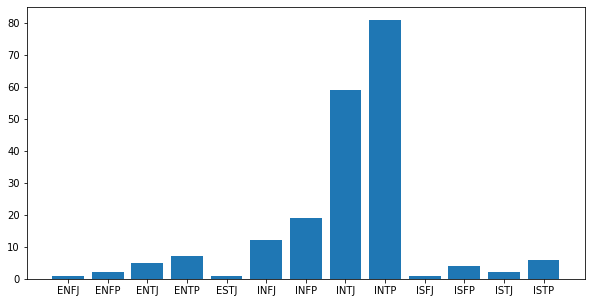

In [122]:
for i in res:
    if i not in res_counter.keys():
        res_counter[i] = 1
    else:
        res_counter[i] += 1

res_keys = sorted(res_counter.keys())
plt.figure(figsize=(10,5))
plt.bar(res_keys, [res_counter[i] for i in res_keys])

## END
@ Karl